In [169]:
using Flux, Distributions, Zygote, ForwardDiff, Plots, StatsPlots, LinearAlgebra, Random

In [311]:
mutable struct HMM
    μ
    σ
    
    P
end
Flux.@functor HMM (μ, σ)

function HMM(states)
    μ = collect(range(-1,1, length=states))
    σ = zeros(states)
    
    P = softmax(Matrix(Diagonal(ones(states))),dims=2)
    
    return HMM(μ,σ,P)
end


function filter(m::HMM, y, p_t)
    
    μ = m.μ
    σ = exp.(m.σ)
    P = m.P
    
    y_t = y[1]
    
    dists_t = Normal.(μ,σ)
    pdfs = pdf.(dists_t, y_t)
    
    sumdist = (p_t.*pdfs)
    p_tt = sumdist./sum(sumdist)
    
    p_tp1 = P*p_tt
    
    if length(y)>1
        dists_tp1, p_t, p_ttp1 = filter(m,y[2:end],p_tp1)
        return vcat(dists_t, dists_tp1), hcat(p_t,p_tp1), hcat(p_tt, p_ttp1)
    else
        return dists_t, p_t, p_tt
    end
end

function forward(m::HMM, y, α_tm1)
    #α(q_0) = p(q_0)p(y_0|q_0)
    
    μ = m.μ
    σ = exp.(m.σ)
    P = m.P
    
    y_t = y[1]
    
    qsum = P*α_tm1
    dists = Normal.(μ,σ)
    pdfs = pdf.(dists,y_t)
 
    α_t = pdfs.*qsum
    
    if length(y)>1
        α_tp1 = forward(m,y[2:end],α_t)
        return hcat(α_t, α_tp1)
    else
        return α_t
    end
end


function backward(m::HMM, y, β_tp1)
    #β_(q_{T-1}) = \sum_{q_T}p(y_T|q_T)p(q_T|q_{T-1})
    
    μ = m.μ
    σ = exp.(m.σ)
    P = softmax(m.P, dims=2)
    
    y_t = y[end]
    
    dists = Normal.(μ,σ)
    pdfs = pdf.(dists,y_t)
    
    β_t = sum(transpose(P).*β_tp1.*pdfs,dims=2)
    
    if length(y)>1
        β_tm1 = backward(m, y[1:end-1], β_tp1)
        return hcat(β_tm1, β_t)
    else
        return β_t
    end
end



function likelihood(m::HMM,y,sps)
    μ = m.μ
    σ = exp.(m.σ)
    
    dists = Normal.(μ,σ)
    
    return mean(map(i->sum(sps[i].*logpdf.(dists,y[i])),1:length(y)))
end


function EM(m::HMM, y, p_0, n_iter = 50)
    
    for i in 1:n_iter
        αβ = backward(m,y,p_0).*forward(m,y,p_0)
        state_probs = αβ./sum(αβ,dims=1)
        
        sps = Flux.unstack(state_probs,dims=2)

        ps, f = Flux.destructure(m)
        
        for _ in 1:50
            grads = ForwardDiff.gradient(x -> -likelihood(f(x),y,sps), ps)
            ps .-= 0.001.*grads
        end
        
        newm = f(ps)
        m.μ = newm.μ
        m.σ = newm.σ
        
        Ps = Matrix(transpose(hcat([sum(state_probs[i:i, 1:end-1].*state_probs[:, 2:end],dims=2)[:] for i in 1:length(p_0)]...)))
        Ps./=sum(Ps,dims=1)
        
        m.P = Ps
        
        if i%50==0
            println(-likelihood(m,y,sps))
        end
    end
end

EM (generic function with 2 methods)

In [312]:
Random.seed!(321)
y = vcat([vcat(0.5 .*randn(10).+3, randn(10), 0.5 .*randn(10).-3) for _ in 1:5]...)

m = HMM(3)
ps, f = Flux.destructure(m)

([-1.0, 0.0, 1.0, 0.0, 0.0, 0.0], Restructure(HMM, ..., 6))

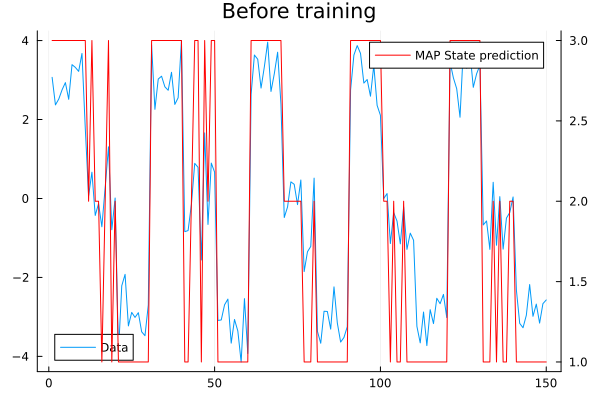

In [313]:
αβ = backward(m,y,ones(3)./3).*forward(m,y,ones(3)./3)
state_probs = αβ./sum(αβ,dims=1)

p1 = plot(y, title = "Before training", label = "Data")
plot!(twinx(), mapslices(x->argmax(x), state_probs,dims=1)[:], label = "MAP State prediction", c="Red")

In [314]:
EM(m,y,ones(3)./3,350)

1.7846321153868878
1.4682240013103964
1.1968795065813052
0.9796988050413751
0.9038611886434182
0.8985764158693441
0.8986812651695267


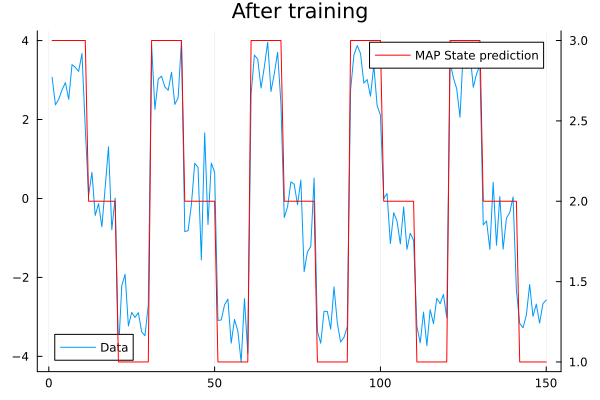

In [315]:
αβ = backward(m,y,ones(3)./3).*forward(m,y,ones(3)./3)
state_probs = αβ./sum(αβ,dims=1)

p2 = plot(y, title = "After training", label = "Data")
plot!(twinx(), mapslices(x->argmax(x), state_probs,dims=1)[:], label = "MAP State prediction", c="Red")

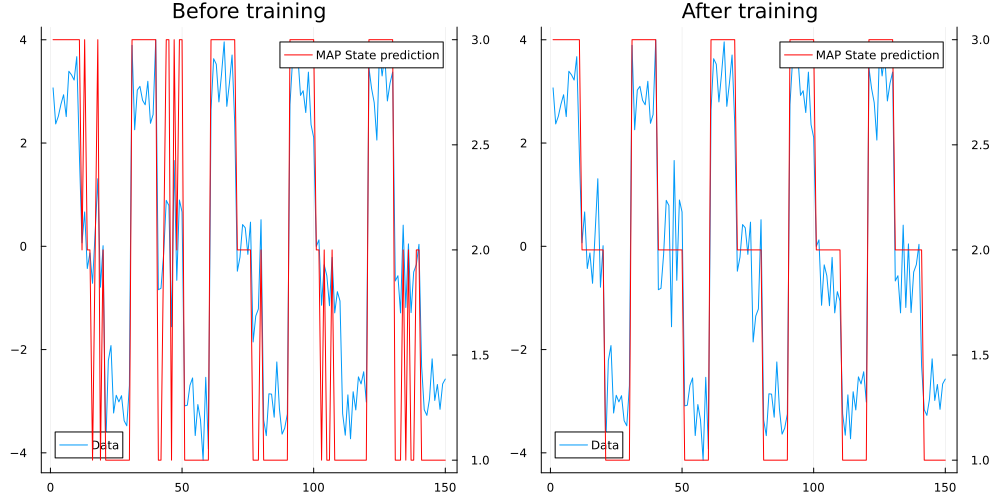

In [316]:
plot(p1,p2,size = (1000,500))